In [ ]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost
Accuracy: 0.9830
Precision: 0.9924
Recall: 0.8792
F1 Score: 0.9324
AUC: 0.9878
Confusion Matrix:


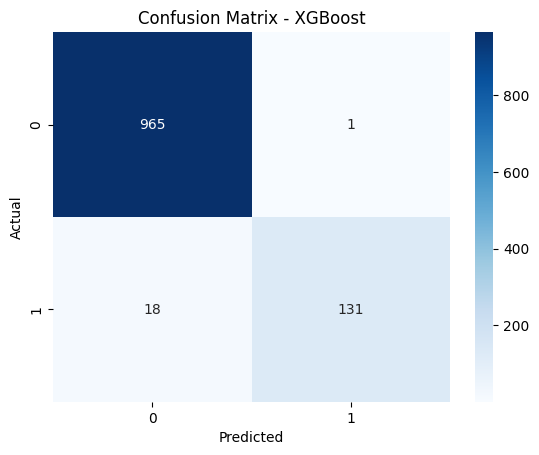

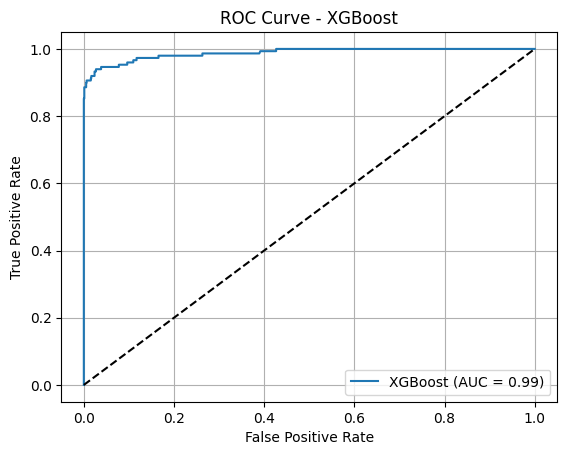

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy.sparse import hstack

nltk.download('stopwords')

def load_and_preprocess():
    df = pd.read_csv('spam.csv', encoding='latin-1')[['v1', 'v2']]
    df.columns = ['label', 'text']

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    def clean_text(text):
        text = re.sub(r'[^\w\s]', '', text.lower())
        return ' '.join(stemmer.stem(word) for word in text.split() if word not in stop_words)

    df['clean_text'] = df['text'].apply(clean_text)
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})
    return df

def add_features(df):
    df['polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df['text_length'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['num_punctuations'] = df['text'].apply(lambda x: sum(c in '!?.,;:\'"()-' for c in x))
    df['num_digits'] = df['text'].apply(lambda x: sum(c.isdigit() for c in x))
    return df

def evaluate_model(model, X_test, y_test, y_prob, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = auc(*roc_curve(y_test, y_prob)[0:2])

    print(f"\nModel: {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print("Confusion Matrix:")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

if __name__ == "__main__":
    df = load_and_preprocess()
    df = add_features(df)

    # TF-IDF
    tfidf = TfidfVectorizer(max_features=500)
    X_tfidf = tfidf.fit_transform(df['clean_text'])

    # Numeric features
    numeric_features = df[['polarity', 'subjectivity', 'text_length', 'word_count', 'num_punctuations', 'num_digits']].values
    scaler = StandardScaler()
    numeric_scaled = scaler.fit_transform(numeric_features)

    # Combine
    X = hstack([X_tfidf, numeric_scaled])
    y = df['label'].values

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Model: XGBoost
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                          scale_pos_weight=y_train.sum() / (len(y_train) - y_train.sum()),
                          random_state=42)
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]
    evaluate_model(model, X_test, y_test, y_prob, "XGBoost")